In [27]:
# Initialize modules
import pandas as pd
import numpy as np
import censusdata
import matplotlib.pyplot as plt
from sodapy import Socrata
pd.set_option('display.precision', 2)

# Load Census Data from US Census Bureau
censustable = censusdata.download('acs5', 2019, censusdata.censusgeo([('state', '06'), \
                        ('county', '085'), ('tract', '*')]), ['B02001_001E', 'B02001_002E'])
censustable['Percent White Only'] = censustable['B02001_002E'].div(censustable['B02001_001E'])*100
censusdata.export.exportcsv("census.csv", censustable)
census= pd.read_csv('census.csv')

# Load Covid-19 data from the County of Santa Clara
client = Socrata("data.sccgov.org", None)
# Get Covid-19 Case Rate by Tract data
results = client.get("can9-fquj", limit=2000)
# Convert to pandas DataFrame
covidcases = pd.DataFrame.from_records(results)
# Get Covid-19 Positivity Rate by Tract data
results2 = client.get("kbj4-a63r", limit=2000)
# Convert to pandas DataFrame
covidpos = pd.DataFrame.from_records(results2)
# Get Covid-19 Vax data
results3 = client.get("8vv7-38uc", limit=2000)
# Convert to pandas DataFrame
vaxrate = pd.DataFrame.from_records(results3)
# Get Covid-19 Test data
results4 = client.get("qnke-t7h7", limit=2000)
# Convert to pandas DataFrame
testrate = pd.DataFrame.from_records(results4)
# Convert tract numbers
covidcases['tract'] = pd.to_numeric(covidcases['tract']) - 6085000000
covidpos['tract'] = pd.to_numeric(covidpos['tract']) - 6085000000
vaxrate['tract'] = pd.to_numeric(vaxrate['tract']) - 0
testrate['tract'] = pd.to_numeric(testrate['tract']) - 6085000000

# Merge and tidy datasets
newone = pd.merge(left=covidpos, right=covidcases, left_on="tract", right_on="tract")
newone['caserate'] = pd.to_numeric(newone['case_rate']) / 1000
newerone = newone[{'tract', 'caserate', 'pos_rate'}]
newertwo = pd.merge(left=newerone, right=census, left_on="tract", right_on="tract")
newertwo = newertwo.drop(columns=['state', 'county', 'NAME', 'B02001_001E', 'B02001_002E'])
newertwo['vaxrate'] = pd.to_numeric(vaxrate['vacc12_count']) / pd.to_numeric(vaxrate['popu_12']) * 100
newertwo['testrate'] = pd.to_numeric(testrate['test_rate']) / 1000
# Number rows
newertwo['row_num'] = np.arange(len(newertwo['tract']))

# Subroutine finished
print("Dataframe initialized.")

Dataframe initialized.
    pos_rate   tract  caserate  Percent White Only  vaxrate  testrate  row_num
0          3  505301      7.14               31.94    92.78    178.99        0
1          2  509901      5.11               65.89    78.54    136.23        1
2        NaN  504700       NaN               88.78    79.19    167.38        2
3        5.9  503322     10.63               36.55    96.43    181.20        3
4        1.2  511200      3.34               67.50    84.62    161.79        4
..       ...     ...       ...                 ...      ...       ...      ...
367        1  510300      2.57               65.47    91.55    130.95      367
368      2.7  502901      5.09               66.71    89.41    279.99      368
369      5.3  503108      8.98               40.15    85.54    217.71      369
370        3  502601      5.69               85.37   112.51    203.10      370
371      3.6  508507      5.23               26.73    66.23    274.75      371

[372 rows x 7 columns]


<Figure size 3600x1800 with 0 Axes>

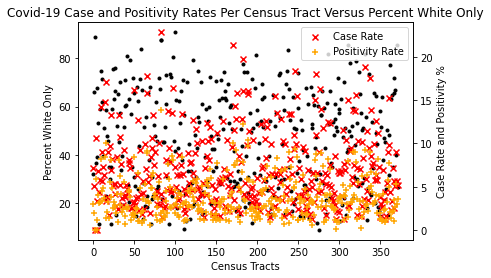

In [19]:
# Define plotdata() function
def plotdata(framename):
  plt.figure(figsize=(12, 6), dpi=300)
  fig,ax = plt.subplots()
  x = pd.to_numeric(framename['row_num'])
  y = pd.to_numeric(framename['Percent White Only'])
  ax.scatter(x, y, marker='.', color='black', label="Percent White Only")
  plt.ylabel('Percent White Only')
  plt.xlabel('Census Tracts')
  plt.title('Covid-19 Case and Positivity Rates Per Census Tract Versus Percent White Only') 
  ax2=ax.twinx()
  x = pd.to_numeric(framename['row_num'])
  y = pd.to_numeric(framename['caserate'])
  ax2.scatter(x, y, marker='x', color='red', label="Case Rate")
  x = pd.to_numeric(framename['row_num'])
  y = pd.to_numeric(framename['pos_rate'])
  ax2.scatter(x, y, marker='+', color='orange', label="Positivity Rate")
  plt.ylabel('Case Rate and Positivity %')
  plt.legend()
 

# Clean dataframes
newertwo['pos_rate'].fillna(value=0, inplace=True)
newertwo['caserate'].fillna(value=0, inplace=True)

# Plot unsorted data
plotdata(newertwo)

<Figure size 3600x1800 with 0 Axes>

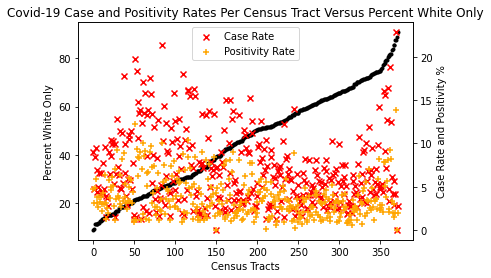

In [20]:
# Sort tracts by "Percent White Only"
newerthree = newertwo.sort_values(by=['Percent White Only'], axis=0, inplace=False)
newerthree['row_num'] = np.arange(len(newerthree['tract']))

# Plot sorted data
plotdata(newerthree)


<Figure size 3600x1800 with 0 Axes>

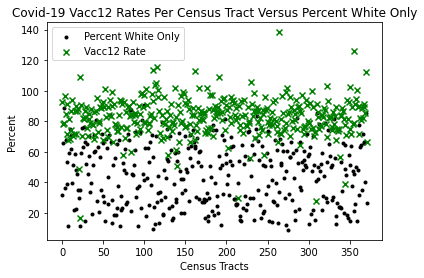

In [39]:
# Define plotdata() function
def plotvax(framename):
  plt.figure(figsize=(12, 6), dpi=300)
  fig,ax = plt.subplots()
  x = pd.to_numeric(framename['row_num'])
  y = pd.to_numeric(framename['Percent White Only'])
  ax.scatter(x, y, marker='.', color='black', label="Percent White Only")
  plt.ylabel('Percent')
  plt.xlabel('Census Tracts')
  plt.title('Covid-19 Vacc12 Rates Per Census Tract Versus Percent White Only') 
  x = pd.to_numeric(framename['row_num'])
  y = pd.to_numeric(framename['vaxrate'])
  ax.scatter(x, y, marker='x', color='green', label="Vacc12 Rate")
  plt.legend()
    
plotvax(newertwo)

<Figure size 3600x1800 with 0 Axes>

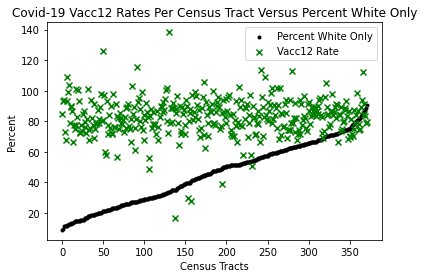

In [40]:
newerfour = newertwo.sort_values(by=['Percent White Only'], axis=0, inplace=False)
newerfour['row_num'] = np.arange(len(newerthree['tract']))
plotvax(newerfour)

<Figure size 3600x1800 with 0 Axes>

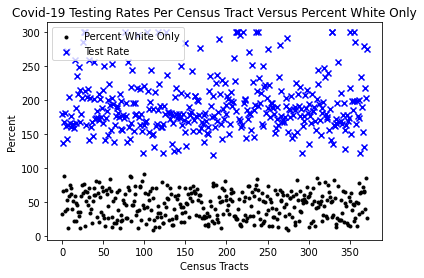

In [37]:
# Define plottest() function
def plottest(framename):
  plt.figure(figsize=(12, 6), dpi=300)
  fig,ax = plt.subplots()
  x = pd.to_numeric(framename['row_num'])
  y = pd.to_numeric(framename['Percent White Only'])
  ax.scatter(x, y, marker='.', color='black', label="Percent White Only")
  plt.ylabel('Percent')
  plt.xlabel('Census Tracts')
  plt.title('Covid-19 Testing Rates Per Census Tract Versus Percent White Only') 
  x = pd.to_numeric(framename['row_num'])
  y = pd.to_numeric(framename['testrate'])
  ax.scatter(x, y, marker='x', color='blue', label="Test Rate")
  plt.legend()
    
newertwo['testrate'].values[newertwo['testrate'].values > 300] = 300
plottest(newertwo)

<Figure size 3600x1800 with 0 Axes>

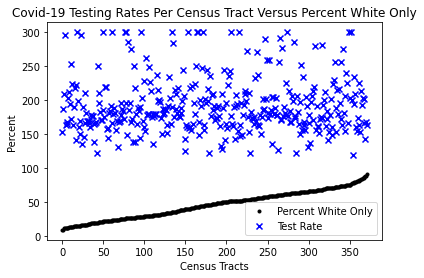

In [38]:

newerfive = newertwo.sort_values(by=['Percent White Only'], axis=0, inplace=False)
newerfive['row_num'] = np.arange(len(newerfive['tract']))
plottest(newerfive)